In [11]:
import pandas as pd
import numpy as np
import seaborn as sns

#!pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import umap

%config InlineBackend.figure_format = 'retina' # для более четкой отрисовки графиков

In [2]:
ds = pd.read_excel('5.4 fire_dataset_bin.xlsx', index_col=0)
ds = ds.drop(['lon', 'lat', 'Dist_str', 'Dist_railw', 'Dist_car'], axis=1) # удалим признаки описывающие только термоточку
print('Размер датасета: {}'.format(ds.shape))

Размер датасета: (8166, 16)


In [3]:
ds.head() # стобец "area" - целевой признак

,area,T,Po,P,Pa,U,DD,Ff,N,WW,Cl,Nh,H,Cm,VV,Td
2017-09-24 10:00:00,0,9.4,761.9,774.8,0.1,71,"Ветер, дующий с востока",2,100%.,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",50%.,600-1000,"Высококучевые просвечивающие, расположенные на...",10.0,4.3
2017-09-24 13:00:00,0,11.7,762.4,775.2,0.5,56,"Ветер, дующий с северо-северо-востока",3,70 – 80%.,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,3.1
2017-09-24 16:00:00,0,11.6,762.7,775.6,0.3,53,"Ветер, дующий с северо-востока",2,70 – 80%.,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,2.3
2017-09-24 19:00:00,0,7.7,763.3,776.4,0.6,64,"Ветер, дующий с северо-востока",2,70 – 80%.,NaN,"Кучево-дождевые лысые с кучевыми, слоисто-куче...",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,1.2
2017-09-24 22:00:00,0,6.1,763.6,773.7,0.3,77,"Ветер, дующий с севера",1,Облаков нет.,NaN,"Кучево-дождевые лысые с кучевыми, слоисто-куче...",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,2.3


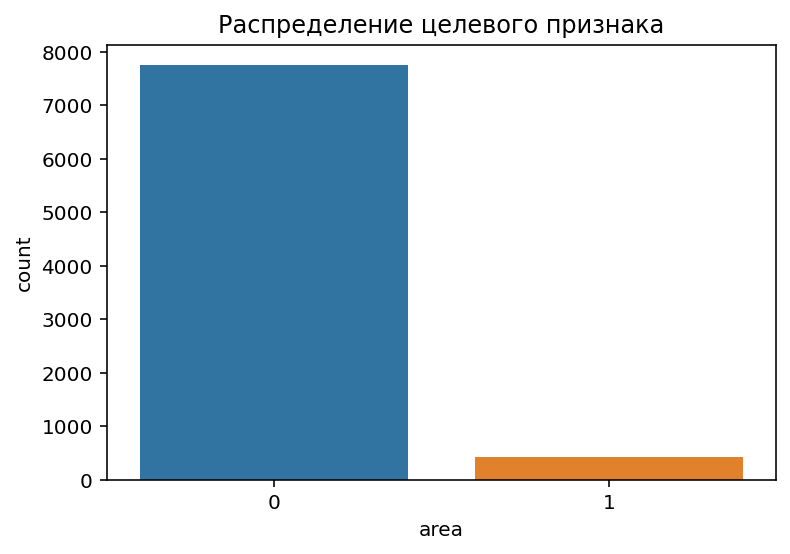

In [4]:
sns.countplot(x=ds['area']).set_title('Распределение целевого признака');

In [24]:
print('В датасете целевой класс распределен: \n{}'.format(ds['area'].value_counts()))

В датасете целевой класс распределен: 
0    7744
1     422
Name: area, dtype: int64


Из гистограммы очевидно, что классы в данном датасете сильно несбаллансированны.

Для баллансировки клаасов можно применять два подхода:
- upsampling (уравновешивание классов путем генерации новых экземпляров меньшего класса)
- downsampling (уравновешивание классов путем удаления экземпляров большего класса)

Для обоих подходов можно воспользоваться библиотечкой imblearn, в которой реализованы алгоритмы генерации, удаления и перераспределения экземляров класса, такие как SMOTE, ADASYN и другие.

In [5]:
ds_num = ds.select_dtypes(exclude='O') # выберем только численные признаки
x = ds_num.copy()
y = x.pop('area') # отделим целевую переменную

Отмасштабируем все признаки и понизим размерность до 2 для визуализации данных:

In [14]:
scl = StandardScaler()
x_scl = scl.fit_transform(x) # отмасштабируем признаки
umap_transform = umap.UMAP(n_components=2)
x_umap = umap_transform.fit_transform(x_scl) # понижаем размерность

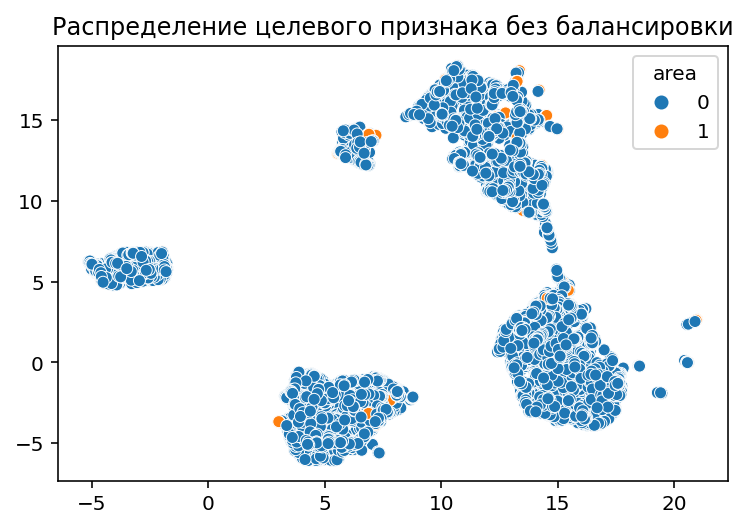

In [15]:
sns.scatterplot(x=x_umap[:,0], y=x_umap[:,1], hue=y).set_title('Распределение целевого признака без балансировки');

Проведем балансировку классов, путем генерации новых синтетических признаков меньшего класса:

In [27]:
over = SMOTE(sampling_strategy=0.7) # установим соотношение размеров классов равным 0.7
x_over, y_over = over.fit_resample(x_scl, y)
print('Распределение классов после ребалансировки: \n{}'.format(y_over.value_counts()))

Распределение классов после ребалансировки: 
0    7744
1    5420
Name: area, dtype: int64


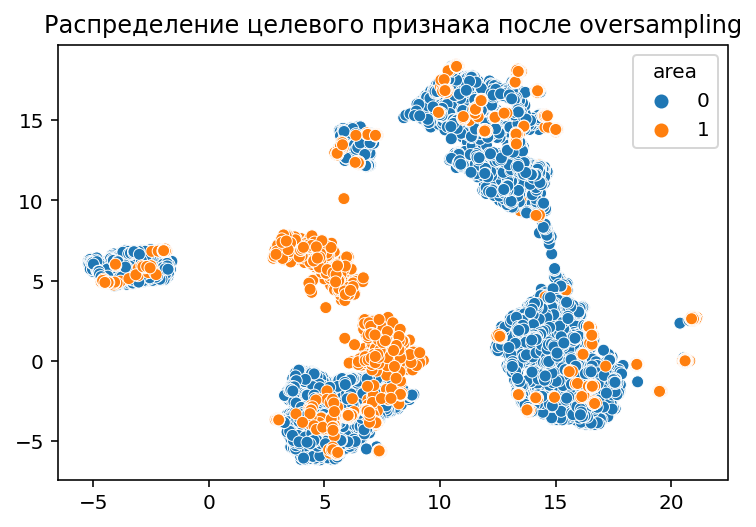

In [28]:
sns.scatterplot(x=umap_transform.transform(x_over)[:,0], 
                y=umap_transform.transform(x_over)[:,1], 
                hue=y_over).set_title('Распределение целевого признака после oversampling');

Теперь проведем балансировку путем удаления экземпляров большего класса:

In [29]:
under = RandomUnderSampler(sampling_strategy=0.7) # установим соотношение размеров классов равным 0.7
x_under, y_under = under.fit_resample(x_scl, y)
print('Распределение классов после ребалансировки: \n{}'.format(y_under.value_counts()))

Распределение классов после ребалансировки: 
0    602
1    422
Name: area, dtype: int64


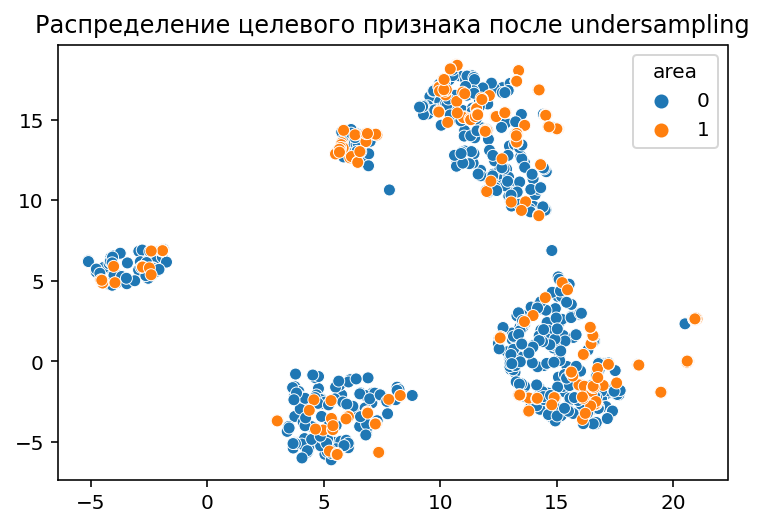

In [30]:
sns.scatterplot(x=umap_transform.transform(x_under)[:,0], 
                y=umap_transform.transform(x_under)[:,1], 
                hue=y_under).set_title('Распределение целевого признака после undersampling');

Рекомендуем попробовать разные алгоритмы для oversampling и undersamping, например, ADASYN, SVMSMOTE, комбинацию oversampling и undersampling, визуализировать результаты и посмотреть отличия.